In [1]:
import pandas as pd

df=pd.read_csv("./emergency_call_binary.csv", encoding="utf-8-sig")
df.head()

id                      document label
0   1    골목길에서 싸움이 났어요, 다친 사람이 있어요.    긴급
1   2       교통사고가 발생했는데 상대방이 도주했어요.    긴급
2   3       집 근처에서 폭죽 소리가 나고 시끄러워요.    경미
3   4  술집에서 손님끼리 다투고 있어요, 경찰이 필요해요.    긴급
4   5         차에 누가 돌을 던졌어요, 잡아주세요.    경미

In [2]:
padding_len = 16
embedding_dim = 1024

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['document'].apply(lambda x: ' '.join(x)))
sequences = tokenizer.texts_to_sequences(df['document'].apply(lambda x: ' '.join(x)))
X = pad_sequences(sequences, maxlen=padding_len, padding='post')

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (300, 16), y shape: (300,)


In [4]:
import numpy as np
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")


vocab_size: 366
max index in sequences: 365


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim  ),
    SimpleRNN(64, return_sequences=False),  # 순서유지 =은닉층
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.4648 - loss: 0.6936 - val_accuracy: 0.5208 - val_loss: 0.8219
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7589 - loss: 0.5162 - val_accuracy: 0.6667 - val_loss: 0.6519
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9371 - loss: 0.2008 - val_accuracy: 0.7083 - val_loss: 1.0218
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9740 - loss: 0.0551 - val_accuracy: 0.6250 - val_loss: 1.4563
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9926 - loss: 0.0234 - val_accuracy: 0.7083 - val_loss: 1.3818
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9605 - loss: 0.1199 - val_accuracy: 0.6667 - val_loss: 1.4075
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9637 - loss: 0.0956 - val_accuracy: 0.6875 - val_loss: 1.2403
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.6458 - val_loss: 1.2651

In [7]:
choice = 'SimpleRNN'

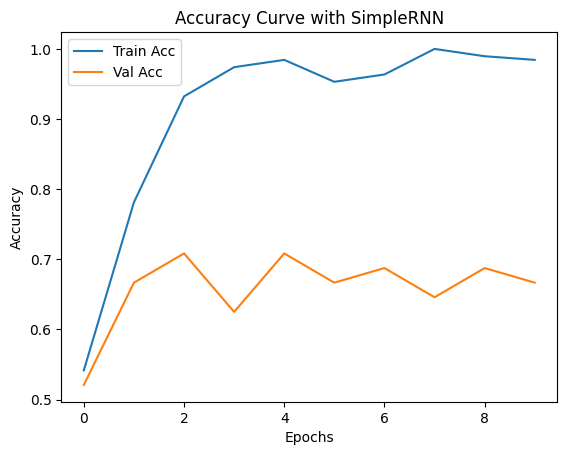

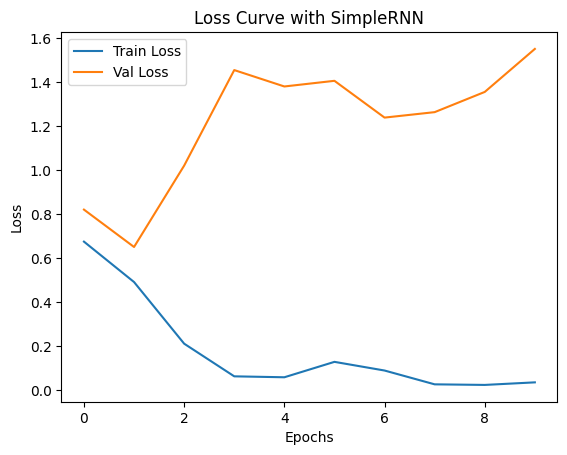

Test Accuracy of SimpleRNN: 0.7000, Loss: 0.6362


In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy of {choice}: {acc:.4f}, Loss: {loss:.4f}")
